#### Exemplo comentado para detecção de Faces utilizando SageMaker na AWS 

##### Importante que o tamanho da imagem seja inferior a 4096 x 4096 pixels

In [6]:
#importação das bibliotecas necessárias para realizar o procedimento de detecção 

import boto3 #representa o AWS SDK para Python (Boto3), que é a biblioteca Python da AWS 
from skimage import io #importando  a biblioteca skimage que possui ferramentas para manipulação das imagens
from skimage.transform import rescale #importando um "modulo" transform da skimagem voltado para redimensionamento da imagem se necessário
from matplotlib import pyplot as plt #importando a pyplot da matplot para mostrar as imagens
from PIL import Image, ImageDraw, ImageColor, ImageOps #importando recursos da biblioteca PIL para poder "desenhar" na imagem

import numpy as np #importando a numpy para manipular dados e realização de alguns calculos da imagem


In [ ]:
#etapa 1 : Criar uma coleção para análise dentro do serviço Amazon Rekognition

# os códigos abaixo só precisam ser executados uma única vez dentro do ambiente AWS onde será feito o reconhecimento

colecao = boto3.client('rekognition') #criando um "cliente" do serviço rekognition
id_colecao = 'Collection' #atribuindo o nome "coleção" padrão da AWS para a coleção de imagens
resposta_criacao = colecao.create_collection(CollectionId=id_colecao) #criando definitivamente a coleção dentro da AWS 



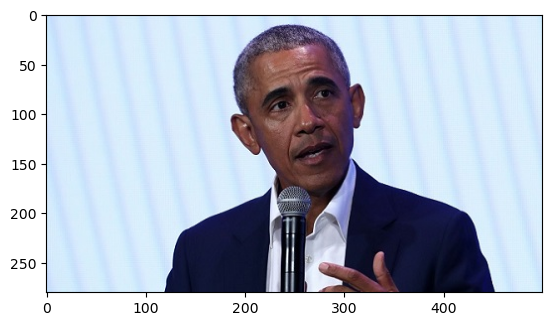

In [9]:
#etapa 2: Realizar o upload da imagem para o procedimento

nome_imagem = 'barack_obama_1.jpg' #passando o nome da imagem para uma variavel

#criando uma variavel para trabalhar como auxiliar no processo de identificação do rosto, onde ela irá receber a imagem do rosto
rosto_imagem = io.imread(nome_imagem)  

plt.imshow(rosto_imagem) #mostrando a imagem carregada


In [11]:
#etapa 3: adicionando a imagem dentro da coleção da AWS para que possa ser processada pelo AWS Rekognition

img_colecao = nome_imagem
#fazendo o uso da função open para "abrir" e ler a imagem e passar os dados binários para o AWS, indicando quantos rostos existem
# o parametro rb indica "leitura binaria"
with open(nome_imagem, 'rb') as fimage:
    response = colecao.index_faces(CollectionId = id_colecao,
                             Image={'Bytes': fimage.read()},
                             ExternalImageId=img_colecao,
                             MaxFaces=1,
                             QualityFilter="AUTO",
                             DetectionAttributes=['ALL'])

print('Resultados para a imagem: ' + nome_imagem)
print('Rostos indexados:')

#o for abaixo serve para delimitar onde será realizado um desenho de um quadrado chamado de BoundingBox no rosto que está na imagem
for faceRecord in response['FaceRecords']:
     print('  ID do rosto: ' + faceRecord['Face']['FaceId'])
     print('  Local do box: {}'.format(faceRecord['Face']['BoundingBox']))

#o for abaixo serve para mostrar caso algum rosto não tenha sido indexado na imagem e por qual razão
print('Rostos não indexados:')
for unindexedFace in response['UnindexedFaces']:
    print(' Local do box: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
    print(' Motivo:')
    for reason in unindexedFace['Reasons']:
        print('   ' + reason)

Resultados para a imagem: barack_obama_1.jpg
Rostos indexados:
  ID do rosto: 74fe3c5b-a769-4dd1-a23c-25273e6dc278
  Local do box: {'Width': 0.2066790759563446, 'Height': 0.5096652507781982, 'Left': 0.4067511558532715, 'Top': 0.10436131805181503}
Rostos não indexados:


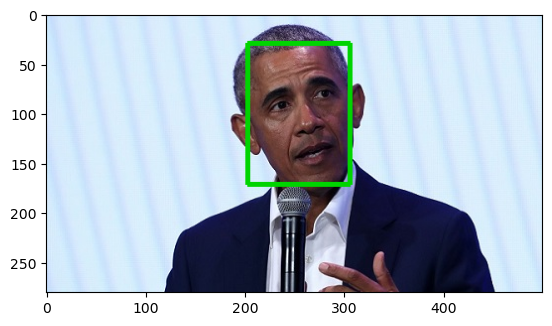

In [15]:
#Etapa 4: Visualizar o box criado no rosto da imagem, identificando o rosto

img = Image.open(nome_imagem) #abrindo a imagem dentro da variavel img juntamente com os parametros de seu tamanho, altura e largura
imgWidth, imgHeight = img.size

draw = ImageDraw.Draw(img) #chamando a função Draw para desenhar o Box na imagem de acordo com o que foi delimitado
for faceRecord in response['FaceRecords']:
    box = faceRecord['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left,top),(left+width,top),(left+width,top+height),(left,top+height),(left,top)) 

    draw.line(points,fill='#00d400', width=5) #o padrão width delimita a espessura do quadrado que será desenhado na imagem
    
plt.imshow(img) #mostrando a imagem com o quadrado

In [16]:
#Etapa 5: realizando o recarregamento da imagem com o box criado para poder realizar uma futura comparação com outra imagem 
# que contenha o mesmo rosto identificado, a fim de verificar se ele será identificado corretamente e qual a similaridade entre os rostos

maxResults=2 
faces_count=0
tokens=True

response=colecao.list_faces(CollectionId=id_colecao, #trazendo para uma variavel response o id da coleção existente
                           MaxResults=maxResults)

#o while abaixo irá trazer e todos os pontos da primeira imagem que foram armazenados na coleção após a construção do Box, 
# esses dados serão utilizado para realizar a comparação com a outra imagem
while tokens:

    faces=response['Faces']

    for face in faces:
        print (face)
        faces_count+=1
    if 'NextToken' in response:
        nextToken=response['NextToken']
        response=client.list_faces(CollectionId=collection_id,
                                   NextToken=nextToken,MaxResults=maxResults)
    else:
        tokens=False

{'FaceId': '74fe3c5b-a769-4dd1-a23c-25273e6dc278', 'BoundingBox': {'Width': 0.20667900145053864, 'Height': 0.5096650123596191, 'Left': 0.40675100684165955, 'Top': 0.10436099767684937}, 'ImageId': '5696db3a-98ec-3113-93fc-58db0b402484', 'ExternalImageId': 'barack_obama_1.jpg', 'Confidence': 99.99930572509766, 'IndexFacesModelVersion': '6.0'}


Combinação de rostos:
ID do Rosto:74fe3c5b-a769-4dd1-a23c-25273e6dc278
Similaridade: 100.00%
ID imagem 2: barack_obama_1.jpg


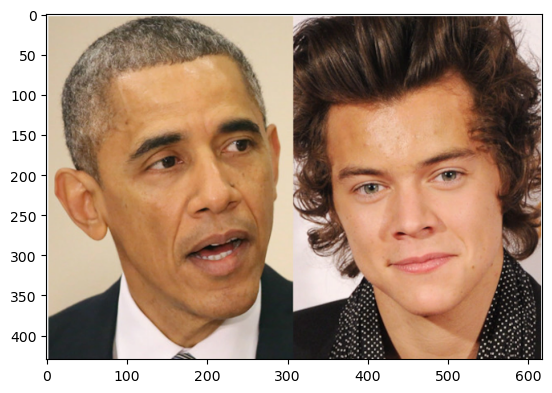

In [17]:
#Etapa 6: Agora serão utilizados os dados da 1 imagem armazenado na "Coleção" para poder identificar 
# o mesmo rosto em uma outra imagem externa

imagem2 = 'barack_obama_2.png' #trazendo o nome da imagem 2 para dentro de uma variavel

alvo_img = Image.open(imagem2) #criando uma variavel a mais chamado de alvo para receber a imagem dentro do programa
plt.imshow(alvo_img) #mostra a imagem 2

threshold = 70 #definindo um "limite" para analise de pixels da imagem que será convertida para binario
maxFaces=2 #passando um valor máximo de rostos nessa imagem 2

#a função open abaixo realiza o mesmo procedimento para ler a imagem 2 no formato binário(rb), porém, com uma função diferente 
# aqui é chamado junto a função search faces que contém um procedimento para buscar na imagem2 (aberta) os dados criados na imagem 1
# podendo assim identificar se existe o mesmo rosto na imagem 2
with open(imagem2, 'rb') as timage:        
    response2=colecao.search_faces_by_image(CollectionId=id_colecao,
                            Image={'Bytes': timage.read()},
                            FaceMatchThreshold=threshold,
                            MaxFaces=maxFaces)

faceMatches=response2['FaceMatches']
print ('Combinação de rostos:')
for match in faceMatches:
        print ('ID do Rosto:' + match['Face']['FaceId'])
        print ('Similaridade: ' + "{:.2f}".format(match['Similarity']) + "%")
        print ('ID imagem 2: ' + match['Face']['ExternalImageId'])
        

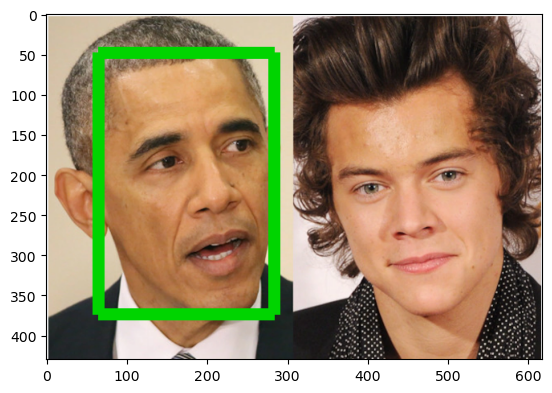

In [21]:
#Etapa 7: Após a identificação da similaridade iremos plotar abaixo um box no rosto que foi identificado como igual ao da imagem 1

imgWidth, imgHeight = alvo_img.size

draw = ImageDraw.Draw(alvo_img)

box = response2['SearchedFaceBoundingBox']
left = imgWidth * box['Left']
top = imgHeight * box['Top']
width = imgWidth * box['Width']
height = imgHeight * box['Height']

points = ((left,top),(left+width,top),(left+width,top+height),(left,top+height),(left,top))
draw.line(points,fill='#00d400', width=5)
    
plt.imshow(alvo_img)

In [ ]:
#Último passo é deletar a coleção criada dentro do ambiente AWS

print('deletar a coleção: ' + id_colecao)
status_code=0
try:
    response=colecao.delete_collection(CollectionId=collection_id)
    status_code=response['StatusCode']
    print('Excluida!')
    print(status_code)
    
except ClientError as e:
    if e.response['Error']['Code'] == 'ResourceNotFoundException':
        print ('A coleção ' + collection_id + ' não foi encontrada ')
    else:
        print ('Erro ocorrido: ' + e.response['Error']['Message'])
    status_code=e.response['ResponseMetadata']['HTTPStatusCode']
